In [26]:
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [27]:
stock_symbol = 'A' #place the stock symbol


df = pd.read_csv(f'stock_datasets/{stock_symbol}_daily_data.csv')
print(df.head())
print(df.shape)

                        Date       Open       High        Low      Close  \
0  1999-11-18 00:00:00-05:00  27.509944  30.230710  24.184566  26.603024   
1  1999-11-19 00:00:00-05:00  25.960617  25.998406  24.071199  24.411295   
2  1999-11-22 00:00:00-05:00  24.978122  26.603024  24.222354  26.603024   
3  1999-11-23 00:00:00-05:00  25.696096  26.376287  24.184561  24.184561   
4  1999-11-24 00:00:00-05:00  24.260149  25.356013  24.184571  24.826975   

     Volume  Dividends  Stock Splits Symbol  
0  62546380        0.0           0.0      A  
1  15234146        0.0           0.0      A  
2   6577870        0.0           0.0      A  
3   5975611        0.0           0.0      A  
4   4843231        0.0           0.0      A  
(6284, 9)


In [28]:
symbol = df['Symbol'].unique()[0]
print(symbol)

A


In [29]:
print(df.isna().sum())
df = df.dropna()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Symbol          0
dtype: int64


In [30]:

df.drop(columns=['Dividends', 'Stock Splits', 'Symbol'], inplace=True) #these columns won't be needed for forecasts


#for testing purposes let's only consider historical data for the moment
#df = df[['Date', 'Close']]   

df.head()




,Date,Open,High,Low,Close,Volume
0,1999-11-18 00:00:00-05:00,27.509944,30.230710,24.184566,26.603024,62546380
1,1999-11-19 00:00:00-05:00,25.960617,25.998406,24.071199,24.411295,15234146
2,1999-11-22 00:00:00-05:00,24.978122,26.603024,24.222354,26.603024,6577870
3,1999-11-23 00:00:00-05:00,25.696096,26.376287,24.184561,24.184561,5975611
4,1999-11-24 00:00:00-05:00,24.260149,25.356013,24.184571,24.826975,4843231


In [41]:
#change date

# Ensure the 'Date' column is of string type
df['Date'] = df['Date'].astype(str)

# Now, slice the string to get just the 'YYYY-MM-DD' part
df['Date'] = df['Date'].str[:10]

df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'])
df.set_index('Date', inplace=True )
df.head()


0      1999-11-18
1      1999-11-19
2      1999-11-22
3      1999-11-23
4      1999-11-24
          ...    
6279   2024-11-04
6280   2024-11-05
6281   2024-11-06
6282   2024-11-07
6283   2024-11-08
Name: Date, Length: 6284, dtype: datetime64[ns]


,Open,High,Low,Close,Volume
Date,,,,,
1999-11-18,27.509944,30.230710,24.184566,26.603024,62546380
1999-11-19,25.960617,25.998406,24.071199,24.411295,15234146
1999-11-22,24.978122,26.603024,24.222354,26.603024,6577870
1999-11-23,25.696096,26.376287,24.184561,24.184561,5975611
1999-11-24,24.260149,25.356013,24.184571,24.826975,4843231


In [42]:
fig = px.line(df, x=df.index, y=df['Close'], title=f'Stock prices over time for stock {symbol}')
fig.show()

# Forecasting

In [43]:
#while we're still creating the lstm model, let's use a subset of our dataset



#df_testing = df.loc['2000-01-01':]
df_testing = df
df_testing.shape

(6284, 5)

In [44]:
#train/test split

n = len(df_testing)
training_data = df_testing[0:int(n*0.7)]
validation_data = df_testing[int(n*0.7):int(n*0.9)]
test_data = df_testing[int(n*0.9):]



In [45]:
def df_to_X_Y(df, window_size=8, future_steps=7):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size - future_steps + 1):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size:i+window_size+future_steps, 3]  # Multi-step target
        Y.append(label)
    return np.array(X), np.array(Y)


In [46]:
#df_testing = df_testing[['Close']]
X, Y = df_to_X_Y(df_testing)
X.shape, Y.shape

((6270, 8, 5), (6270, 7))

In [47]:
n = len(df_testing)
threshold = 0.9

X_train, Y_train = X[:int(n*threshold)], Y[:int(n*threshold)]
X_test, Y_test = X[int(n*threshold):], Y[int(n*threshold):]



In [48]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((5655, 8, 5), (5655, 7), (615, 8, 5), (615, 7))

In [49]:

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Flatten X_train for scaling, then reshape back to original shape
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Scale Y_train (multi-step target) as a 2D array (samples, future_steps)
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)  # Ensure consistent scaling


In [50]:
# Build the LSTM model
# Adjust the number of output units to match the future steps (e.g., 7)
future_steps = 7

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(future_steps)  # Output layer predicts 7 future steps
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0170
Epoch 2/40
 11/177 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3535e-04

c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.2779e-04
Epoch 3/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.3878e-04
Epoch 4/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8841e-04
Epoch 5/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7837e-04
Epoch 6/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1069e-04
Epoch 7/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1474e-04
Epoch 8/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1764e-04
Epoch 9/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8314e-04
Epoch 10/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.9491e-04
Epoch 11/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6366e-04
Epoch 12/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.9817e-04
Epoch 13/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8471e-04
Epoch 14/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8271e-04
Epoch 15/40
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7836e-

In [51]:
# Predict on the test set
Y_test_pred_scaled = model.predict(X_test_scaled)  # Shape: (n_samples, future_steps)

# Inverse transform predictions and actual values to the original scale
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred_scaled)  # Shape: (n_samples, future_steps)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)  # Shape: (n_samples, future_steps)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [52]:

# Flatten arrays to calculate overall metrics
Y_test_original_flat = Y_test_original.flatten()
Y_test_pred_flat = Y_test_pred.flatten()

# Calculate overall RMSE and MAE
rmse = np.sqrt(mean_squared_error(Y_test_original_flat, Y_test_pred_flat))
mae = mean_absolute_error(Y_test_original_flat, Y_test_pred_flat)

print(f"Overall RMSE: {rmse}")
print(f"Overall MAE: {mae}")

Overall RMSE: 5.707554180772119
Overall MAE: 4.532462896508766


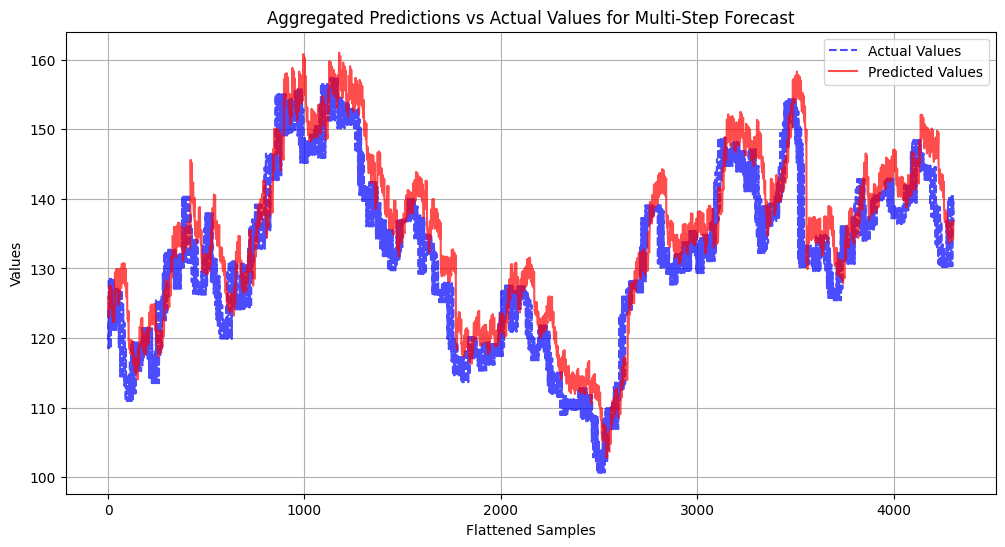

In [53]:
# Flatten the actual and predicted values across all steps
Y_test_original_flat = Y_test_original.flatten()
Y_test_pred_flat = Y_test_pred.flatten()

# Plot aggregated results
plt.figure(figsize=(12, 6))
plt.plot(Y_test_original_flat, label="Actual Values", linestyle='--', color='blue', alpha=0.7)
plt.plot(Y_test_pred_flat, label="Predicted Values", color='red', alpha=0.7)

plt.title(f"Aggregated Predictions vs Actual Values for Multi-Step Forecast")
plt.xlabel("Flattened Samples")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


# Future predictions


In [54]:
def df_to_X_Y(df, window_size=8, future_steps=7):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size - future_steps):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size:i + window_size + future_steps, 3]  # Taking the 'Close' column for future steps
        Y.append(label)
    return np.array(X), np.array(Y)

# Prepare the full dataset with multi-step targets
X_full, Y_full = df_to_X_Y(df_testing, window_size=8, future_steps=7)

# Scale the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_full_scaled = scaler_X.fit_transform(X_full.reshape(-1, X_full.shape[2])).reshape(X_full.shape)
Y_full_scaled = scaler_Y.fit_transform(Y_full)

# Train the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_full_scaled.shape[1], X_full_scaled.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(7)  # Output layer for 7 future steps
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train using the full dataset
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_full_scaled, Y_full_scaled, epochs=40, batch_size=32, callbacks=[early_stopping], verbose=1)

# Get the last window from the scaled data
last_window = X_full_scaled[-1]

# Predict 7 future steps
future_predictions_scaled = model.predict(np.expand_dims(last_window, axis=0))[0]  # Shape: (7,)

# Reshape future_predictions_scaled to have the shape (1, 7) for inverse transformation
future_predictions_scaled_reshaped = future_predictions_scaled.reshape(1, -1)

# Now, inverse transform the predictions
future_predictions = scaler_Y.inverse_transform(future_predictions_scaled_reshaped)

# Since future_predictions is a 2D array (1, 7), we need to flatten it to a 1D array for plotting
future_predictions = future_predictions.flatten()

# Combine historical data and future predictions for plotting
historical_data = df_testing['Close'].values  # Original 'Close' column
future_time_steps = range(len(historical_data), len(historical_data) + 7)  # Future time indices




Epoch 1/40


c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0401
Epoch 2/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.6457e-04
Epoch 3/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4150e-04
Epoch 4/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4740e-04
Epoch 5/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.0486e-04
Epoch 6/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.0053e-04
Epoch 7/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.0372e-04
Epoch 8/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5197e-04
Epoch 9/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.1011e-04
Epoch 10/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.6819e-04
Epoch 11/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.6515e-04
Epoch 12/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.3029e-04
Epoch 13/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.9424e-04
Epoch 14/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.7642e-04
Ep

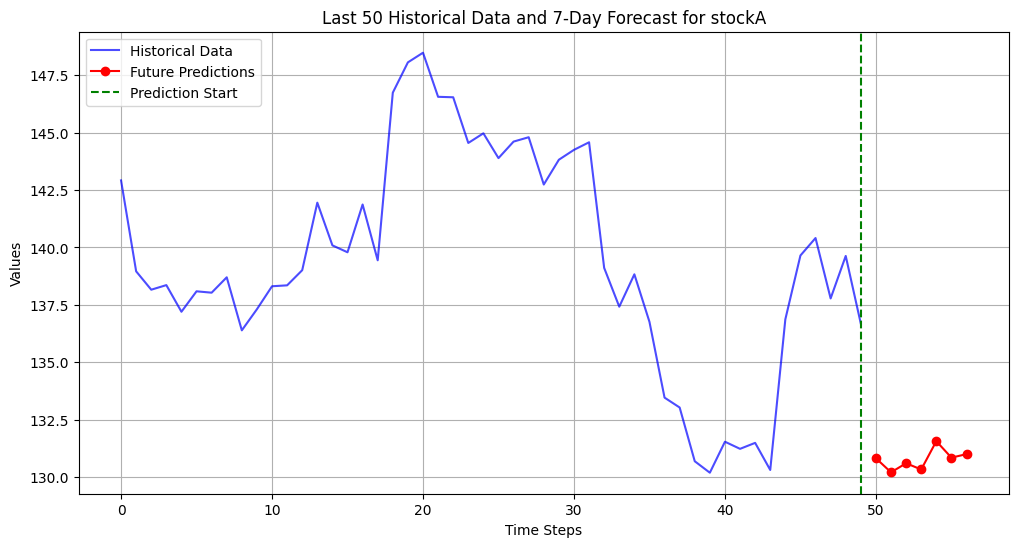

In [55]:


# Get the last 50 values of historical data
historical_data_last_50 = historical_data[-50:]

# Get the corresponding time steps for the last 50 values and the future 7 days
future_time_steps = range(len(historical_data_last_50), len(historical_data_last_50) + 7)  # Future time indices

# Plot historical data (last 50 values) and future predictions
plt.figure(figsize=(12, 6))
plt.plot(historical_data_last_50, label='Historical Data', color='blue', alpha=0.7)
plt.plot(future_time_steps, future_predictions, label='Future Predictions', color='red', marker='o')
plt.axvline(x=len(historical_data_last_50) - 1, color='green', linestyle='--', label='Prediction Start')
plt.title(f"Last 50 Historical Data and 7-Day Forecast for stock{stock_symbol}")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()